# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:

- Determine if an interaction term would be useful for a specific model or set of data
- Create interaction terms out of independent variables in linear regression
- Interpret coefficients of linear regression models that contain interaction terms

## Ames Housing Data

Once again we will be using the Ames Housing dataset, where each record represents a home sale:

In [33]:
# Run this cell without changes
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ames = pd.read_csv('ames.csv', index_col=0)

# Remove some outliers to make the analysis more intuitive
ames = ames[ames["GrLivArea"] < 3000]
ames = ames[ames["LotArea"] < 20_000]
ames

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In particular, we'll use these numeric and categorical features:

In [34]:
# Run this cell without changes
numeric = ['LotArea', '1stFlrSF', 'GrLivArea']
categorical = ['KitchenQual', 'Neighborhood']

## Build a Baseline Model

### Initial Data Preparation

Use all of the numeric and categorical features described above. (We will call this the "baseline" model because we are making a comparison with and without an interaction term. In a complete modeling process you would start with a simpler baseline.)

One-hot encode the categorical features (dropping the first), and center (subtract the mean) from the numeric features.

In [35]:
# Your code here - prepare data for modeling
ames_numeric = ames[numeric].apply(lambda x: x - x.mean())
ames_categorical = pd.get_dummies(ames[categorical], drop_first=True)

X = pd.concat([ames_numeric, ames_categorical], axis=1)
y = ames['SalePrice']

### Build a Model with No Interaction Terms

Using the numeric and categorical features that you have prepared, as well as `SalePrice` as the target, build a StatsModels OLS model.

In [36]:
# Your code here - import relevant libraries and build model

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

### Evaluate the Model without Interaction Terms

Describe the adjusted R-Squared as well as which coefficients are statistically significant. For now you can skip interpreting all of the coefficients.

In [37]:
# Your code here - evaluate the baseline model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     223.6
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:07:26   Log-Likelihood:                -16370.
No. Observations:                1396   AIC:                         3.280e+04
Df Residuals:                    1365   BIC:                         3.297e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.544e+05 

# Your written answer here
- The model overall explains about 83% of the variance in sale price.
- Coefficients for KitchenQual are statistically significant

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

The model overall explains about 83% of the variance in sale price.

We'll used the standard alpha of 0.05 to evaluate statistical significance:
    
* Coefficients for the intercept as well as all continuous variables are statistically significant
* Coefficients for `KitchenQual` are statistically significant
* Coefficients for most values of `Neighborhood` are statistically significant, while some are not. In this context the reference category was `Blmngtn`, which means that neighborhoods with statistically significant coefficients differ significantly from `Blmngtn` whereas neighborhoods with coefficients that are not statistically significant do not differ significantly from `Blmngtn`

</details>

## Identify Good Candidates for Interaction Terms

### Numeric x Categorical Term

Square footage of a home is often worth different amounts depending on the neighborhood. So let's see if we can improve the model by building an interaction term between `GrLivArea` and one of the `Neighborhood` categories.

Because there are so many neighborhoods to consider, we'll narrow it down to 2 options: `Neighborhood_OldTown` or `Neighborhood_NoRidge`.

First, create a plot that has:

* `GrLivArea` on the x-axis
* `SalePrice` on the y-axis
* A scatter plot of homes in the `OldTown` and `NoRidge` neighborhoods, identified by color
  * Hint: you will want to call `.scatter` twice, once for each neighborhood
* A line showing the fit of `GrLivArea` vs. `SalePrice` for the reference neighborhood

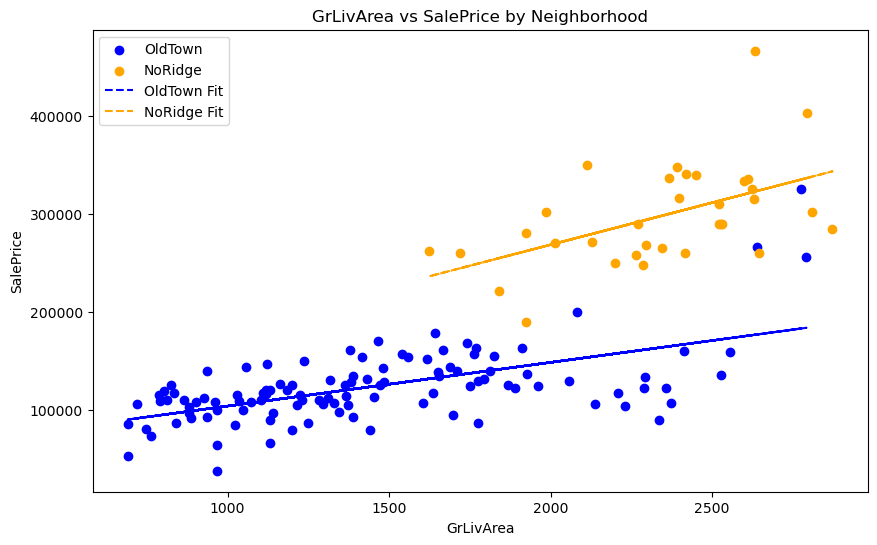

In [38]:
# Your code here - import plotting library and create visualization
plt.figure(figsize=(10, 6))
plt.scatter(ames[ames['Neighborhood'] == 'OldTown']['GrLivArea'], ames[ames['Neighborhood'] == 'OldTown']['SalePrice'], label='OldTown', color='blue')
plt.scatter(ames[ames['Neighborhood'] == 'NoRidge']['GrLivArea'], ames[ames['Neighborhood'] == 'NoRidge']['SalePrice'], label='NoRidge', color='orange')

# Line of best fit for OldTown
oldtown_data = ames[ames['Neighborhood'] == 'OldTown']
oldtown_model = sm.OLS(oldtown_data['SalePrice'], sm.add_constant(oldtown_data['GrLivArea'])).fit()
plt.plot(oldtown_data['GrLivArea'], oldtown_model.predict(sm.add_constant(oldtown_data['GrLivArea'])), color='blue', linestyle='--', label='OldTown Fit')

# Line of best fit for NoRidge
noridge_data = ames[ames['Neighborhood'] == 'NoRidge']
noridge_model = sm.OLS(noridge_data['SalePrice'], sm.add_constant(noridge_data['GrLivArea'])).fit()
plt.plot(noridge_data['GrLivArea'], noridge_model.predict(sm.add_constant(noridge_data['GrLivArea'])), color='orange', linestyle='--', label='NoRidge Fit')

plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.legend()
plt.title('GrLivArea vs SalePrice by Neighborhood')
plt.show()

Looking at this plot, do either of these neighborhoods seem to have a **slope** that differs notably from the best fit line? If so, this is an indicator that an interaction term might be useful.

Identify what, if any, interaction terms you would create based on this information.

# Your written answer here
- The slope of the orange line looks fairly different from the slope of the gray line, indicating that an interaction term for `NoRidge` might be useful.

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

Your plot should look something like this:

![scatter plot solution](https://curriculum-content.s3.amazonaws.com/data-science/images/OldTown_vs_NoRidge.png)

If we drew the expected slopes based on the scatter plots, they would look something like this:

![scatter plot solution annotated](https://curriculum-content.s3.amazonaws.com/data-science/images/OldTown_vs_NoRidge_Annotated.png)

The slope of the orange line looks fairly different from the slope of the gray line, indicating that an interaction term for `NoRidge` might be useful.

</details>

### Numeric x Numeric Term

Let's also investigate to see whether adding an interaction term between two of the numeric features would be helpful.

We'll specifically focus on interactions with `LotArea`. Does the value of an extra square foot of lot area change depending on the square footage of the home? Both `1stFlrSF` and `GrLivArea` are related to home square footage, so we'll use those in our comparisons.

Create two side-by-side plots:

1. One scatter plot of `LotArea` vs. `SalePrice` where the color of the points is based on `1stFlrSF`
2. One scatter plot of `LotArea` vs. `SalePrice` where the color of the points is based on `GrLivArea`

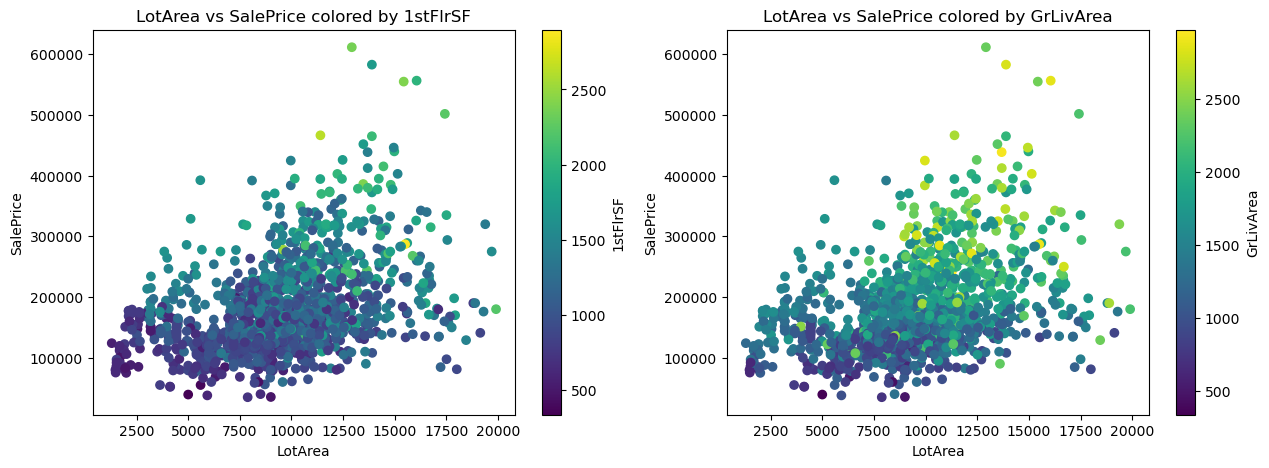

In [31]:
# Your code here - create two visualizations
# 1. Plot LotArea vs SalePrice, colored by 1stFlrSF
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(ames['LotArea'], ames['SalePrice'], c=ames['1stFlrSF'], cmap='viridis')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.title('LotArea vs SalePrice colored by 1stFlrSF')
plt.colorbar(label='1stFlrSF')

# 2. Plot LotArea vs SalePrice, colored by GrLivArea
plt.subplot(1, 2, 2)
plt.scatter(ames['LotArea'], ames['SalePrice'], c=ames['GrLivArea'], cmap='viridis')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.title('LotArea vs SalePrice colored by GrLivArea')
plt.colorbar(label='GrLivArea')

plt.show()

Looking at these plots, does the slope between `LotArea` and `SalePrice` seem to differ based on the color of the point? If it does, that is an indicator that an interaction term might be helpful.

Describe your interpretation below:

# Your written answer here
- For both `1stFlrSF` and `GrLivArea`, it seems like a larger lot area doesn't matter very much for homes with less square footage.

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

Your plots should look something like this:

![side by side plots solution](https://curriculum-content.s3.amazonaws.com/data-science/images/LotArea_vs_SalePrice.png)

For both `1stFlrSF` and `GrLivArea`, it seems like a larger lot area doesn't matter very much for homes with less square footage. (In other words, the slope is closer to a flat line when the dots are lighter colored.) Then for homes with more square footage, a larger lot area seems to matter more for the sale price. (In other words, the slope is steeper when the dots are darker colored.)

This difference in slope based on color indicates that an interaction term for either/both of `1stFlrSF` and `GrLivArea` with `LotArea` might be helpful.

For ease of model interpretation, it probably makes the most sense to create an interaction term between `LotArea` and `1stFlrSF`, since we already have an interaction that uses `GrLivArea`.

</details>

## Build and Interpret a Model with Interactions

### Build a Second Model

Based on your analysis above, build a model based on the baseline model with one or more interaction terms added.

In [29]:
# Your code here - build a model with one or more interaction terms
X['LotArea_x_1stFlrSF'] = X['LotArea'] * X['1stFlrSF']
X['GrLivArea_x_Neighborhood_NoRidge'] = X['GrLivArea'] * X['Neighborhood_NoRidge']
X_const_interact = sm.add_constant(X)
model_interact = sm.OLS(y, X_const_interact).fit()

### Evaluate the Model with Interactions

Same as with the baseline model, describe the adjusted R-Squared and statistical significance of the coefficients.

In [30]:
# Your code here - evaluate the model with interactions
print(model_interact.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     212.1
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:58:36   Log-Likelihood:                -16363.
No. Observations:                1396   AIC:                         3.279e+04
Df Residuals:                    1363   BIC:                         3.296e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

# Your written answer here
- The model overall still explains about 83% of the variance in sale price.

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

The model overall still explains about 83% of the variance in sale price. The baseline explained 82.7% whereas this model explains 82.9%, so it's a marginal improvement.
    
* Coefficients for the intercept as well as all continuous variables are still statistically significant
* Coefficients for `KitchenQual` are still statistically significant
* `Neighborhood_NoRidge` used to be statistically significant but now it is not
* `GrLivArea x Neighborhood_NoRidge` is not statistically significant
* `LotArea x 1stFlrSF` is statistically significant

</details>

### Interpret the Model Results

Interpret the coefficients for the intercept as well as the interactions and all variables used in the interactions. Make sure you only interpret the coefficients that were statistically significant!

# Your written answer here
- The intercept is about 258k.
- The coefficient for LotArea is about 2.58.
- The coefficient for 1stFlrSF is about 30.5.
- The coefficient for LotArea x 1stFlrSF is about 0.003.

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

The intercept is about 258k. This means that a home with average continuous attributes and reference categorical attributes (excellent kitchen quality, Bloomington Heights neighborhood) would cost about \\$258k.

The coefficient for `LotArea` is about 2.58. This means that for a home with average first floor square footage, each additional square foot of lot area is associated with an increase of about \\$2.58 in sale price.

The coefficient for `1stFlrSF` is about 30.5. This means that for a home with average lot area, each additional square foot of first floor area is associated with an increase of about \\$30.50 in sale price.

The coefficient for `LotArea x 1stFlrSF` is about 0.003. This means that:

1. For each additional square foot of lot area, there is an increase of about \\$2.58 + (0.003 x first floor square footage) in sale price
2. For each additional square foot of first floor square footage, there is an increase of about \\$30.50 + (0.003 x lot area square footage) in sale price

`Neighborhood_NoRidge` and `GrLivArea x Neighborhood_NoRidge` were not statistically significant so we won't be interpreting their coefficients.



</details>

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions that seem promising may or may not end up being statistically significant. This is why exploration and iteration are important!